In [1]:
import sys
from datetime import datetime
import os
from os import mkdir
import matplotlib.pyplot as plt

from mpi4py import MPI
import numpy as np
from nvtx import annotate
import multiprocessing
import tomopy

import httomo
from httomo.common import PipelineTasks
from httomo.data.hdf.loaders import standard_tomo
from httomo.data.hdf._utils.save import intermediate_dataset
from httomo.data.hdf._utils.reslice import reslice

In [2]:
# set I/O and other parameters
#in_file = "/scratch/daniil/data/i12/360_scan_stripes/112482.nxs"
in_file = "/media/algol/29B3CEA03D85F0EA/DATA/i12/360scan_large_rings/112482.nxs"
#run_out_dir = os.path.join("/scratch/daniil/data/OUTPUT", f"{datetime.now().strftime('%d-%m-%Y_%H_%M_%S')}_output")
run_out_dir = os.path.join("/media/algol/29B3CEA03D85F0EA/DATA/OUTPUT_SAVU", f"{datetime.now().strftime('%d-%m-%Y_%H_%M_%S')}_output")

data_key = "/entry1/tomo_entry/data/data"
dimension = 1 # load chunks projection-wise
crop = 3 # crop the data if needed (around the mid slice)
pad = 0 # padding data parameter

comm = MPI.COMM_WORLD
if comm.rank == 0:
    mkdir(run_out_dir)
if comm.size == 1:
    ncore = multiprocessing.cpu_count() # use all available CPU cores if not an MPI run

The full dataset shape is (3751, 2160, 2560)
Cropped data shape is (3601, 65, 2560)
[0] Pad values are (0, 0).
/media/algol/29B3CEA03D85F0EA/DATA/i12/360scan_large_rings/112482.nxs
/entry1/tomo_entry/data/data
100: 3701, 1320:1340, :
[0] Data shape is (3601, 20, 2560) of type uint16


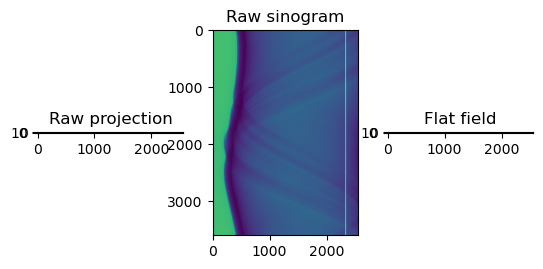

In [3]:
import httomo
import importlib
importlib.reload(httomo.data.hdf.loaders)
from httomo.data.hdf.loaders import standard_tomo

data, flats, darks, angles, angles_total, detector_y, detector_x = standard_tomo(in_file, data_key, dimension, crop, pad, comm)

plt.figure()
plt.subplot(121)
plt.imshow(data[0,:,:])
plt.title('Raw projection')
plt.subplot(122)
plt.imshow(data[:,10,:])
plt.title('Raw sinogram')

#### Normalise data

Text(0.5, 1.0, 'Normalised magnified sinogram')

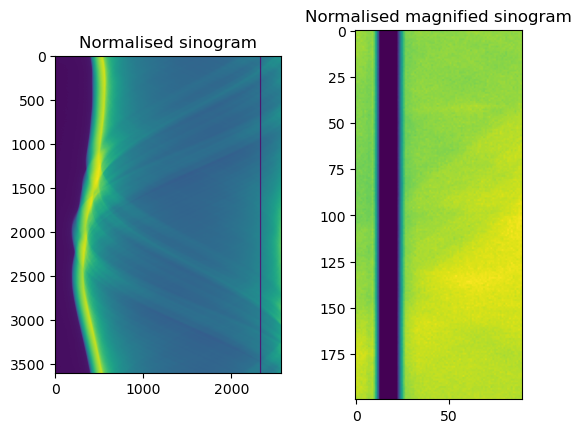

In [4]:
from tomopy.prep.normalize import normalize, minus_log
data = normalize(data, flats, darks, ncore=ncore, cutoff=10)
data[data == 0.0] = 1e-09
data = tomopy.minus_log(data, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[:,10,:])
plt.title('Normalised sinogram')
plt.subplot(122)
plt.imshow(data[0:200,10,2310:2400])
plt.title('Normalised magnified sinogram')
#intermediate_dataset(data, run_out_dir, 'normalised', comm)

#### Perform thresholding of data to get the mask for inpainting

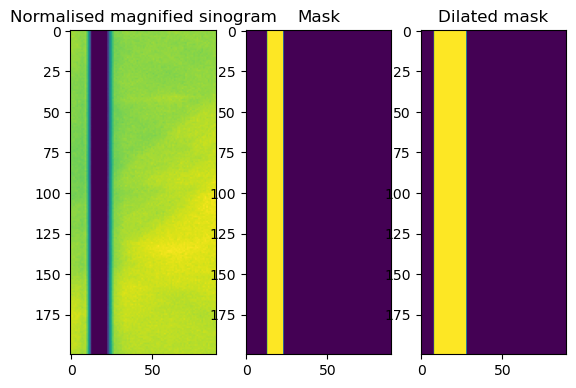

In [37]:
from httomo.misc.segm import binary_thresholding

mask = binary_thresholding(data, val_intensity=-0.0, foreground=False)

plt.figure()
plt.subplot(131)
plt.imshow(data[0:200,10,2310:2400])
plt.title('Normalised magnified sinogram')
plt.subplot(132)
plt.imshow(mask[0:200,10,2310:2400])
plt.title("Mask")

# dilate the mask a bit
from skimage.morphology import disk, binary_dilation
footprint = disk(5)
for i in range(np.size(mask, 1)):
    mask[:,i,:] = binary_dilation(mask[:,i,:], footprint)

plt.subplot(133)
plt.imshow(mask[0:200,10,2310:2400])
plt.title("Dilated mask")
plt.show()

#### Inpaint the data with the mask provided 

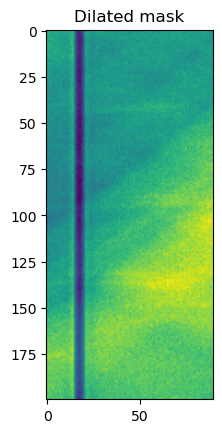

In [61]:
plt.figure()
plt.imshow(data[0:200,16,2310:2400])
plt.title("Dilated mask")
plt.show()

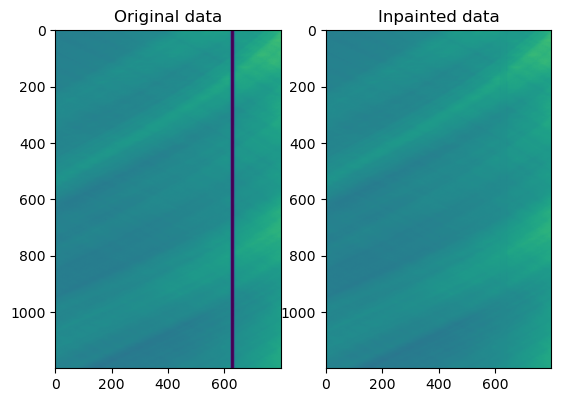

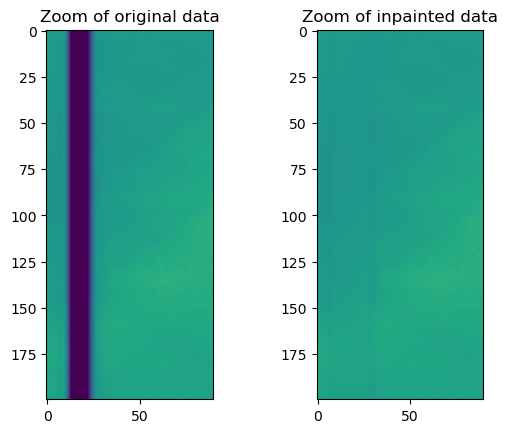

In [46]:
import httomo
import importlib
importlib.reload(httomo.misc.corr)
from httomo.misc.corr import inpainting_filter3d

inpainted_data, updated_mask = inpainting_filter3d(data[:,10,:], mask[:,10,:], 
                                                   number_of_iterations = 20,
                                                   windowsize_half = 15,
                                                   method_type = "random",
                                                   ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[0:1200,10,1700:2500], vmin= 0.0, vmax = 1.8)
plt.title("Original data")
plt.subplot(122)
plt.imshow(inpainted_data[0:1200,1700:2500], vmin= 0.0, vmax = 1.8)
plt.title("Inpainted data")
plt.show()


plt.figure()
plt.subplot(121)
plt.imshow(data[0:200,10, 2310:2400], vmin= 0.0, vmax = 1.8)
plt.title("Zoom of original data")
plt.subplot(122)
plt.imshow(inpainted_data[0:200,2310:2400], vmin= 0.0, vmax = 1.8)
plt.title("Zoom of inpainted data")
plt.show()

In [10]:
from httomo.recon.rotation import find_center_360

(CoR360, overlap, side, overlap_position) = find_center_360(data[:,10,:])
print(CoR360)

1583.096435546875


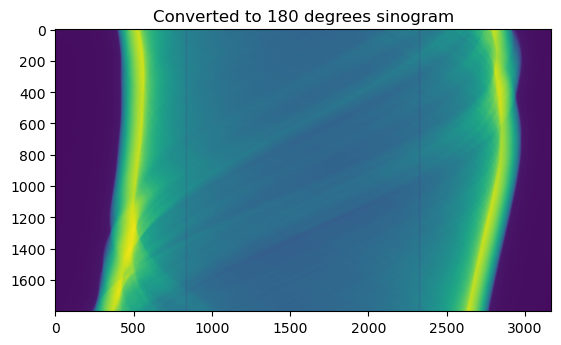

In [13]:
from tomopy.misc.morph import sino_360_to_180

data = sino_360_to_180(data, overlap=overlap, rotation='right')

plt.figure()
plt.imshow(data[:,10,])
plt.title('Converted to 180 degrees sinogram')
plt.show()

In [14]:
data, dimension = reslice(data, run_out_dir, dimension, angles_total, detector_y, detector_x, comm)

/media/algol/29B3CEA03D85F0EA/DATA/OUTPUT_SAVU/01-11-2022_10_26_54_output/intermediate.h5
/data
:,:,:


(20, 3168, 3168)


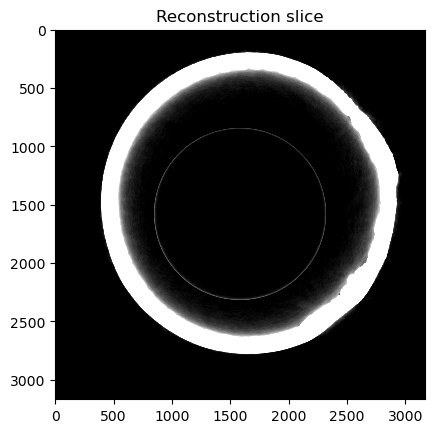

In [15]:
from tomopy.recon.algorithm import recon

recon = recon(data,
    angles,
    center=CoR360,
    algorithm="gridrec",
    sinogram_order=False,
    ncore=ncore)

print(np.shape(recon))
plt.figure()
plt.imshow(recon[10,:,:], cmap='gray', vmin = 0, vmax = 0.001)
plt.title('Reconstruction slice')
plt.show()

In [16]:
# save the resulting dataset to images
import httomo
from httomo.misc.images import save_to_images
from httomo._stats.globals import min_max_mean_std

import importlib
importlib.reload(httomo._stats.globals)
from httomo._stats.globals import min_max_mean_std

importlib.reload(httomo.misc.images)
from httomo.misc.images import save_to_images

# get global stats
glob_stats = min_max_mean_std(recon, comm)
save_to_images(recon, run_out_dir, glob_stats, comm)